In [55]:
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import time
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
plt.rcParams['figure.figsize'] = (14,8)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-08', cached_dir='../../price_data_utils/cached')
dl.load_data()

Prediction Date: 2019-08-12


In [3]:
data = dl.data
data.head()

,mkt_cap,beta,book_value,sector,eps,month_ago,year_ago,prev_date,analysis_date,trade_date,pred_date,volume
ticker,,,,,,,,,,,,
CSCO,229986631680,0.995519,36804000000,Technology,2.882,56.340000,44.558083,52.340000,53.160000,52.430000,51.540001,26093500.0
SITC,2533060352,0.844472,1499137000,Real Estate,1.043,13.500000,NaN,13.780000,14.030000,14.030000,13.920000,1101295.0
UAL,22748133376,1.223721,10320000000,Industrials,9.838,89.459999,85.660004,86.480003,87.629997,86.980003,84.709999,1419900.0
TROW,26297821184,1.069091,6579100000,Financial Services,7.945,109.820000,112.935532,107.040001,110.250000,108.650002,106.610001,1158300.0
ISRG,61556834304,1.269715,7265300000,Healthcare,10.129,528.270020,529.049988,505.359985,519.409973,515.500000,509.880005,461800.0


In [4]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-12')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [5]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,2018-10-29,28.670000,24.500000,28.000000,25.820000,30427500.0,25.820000,REZI
1,2018-10-30,25.000000,20.510000,24.799999,21.059999,8275000.0,21.059999,REZI
2,2018-10-31,22.510000,19.309999,21.219999,21.049999,8148700.0,21.049999,REZI
3,2018-11-01,23.730000,20.420000,20.879999,22.000000,10101600.0,22.000000,REZI
4,2018-11-02,23.969999,20.549999,22.000000,23.780001,8104600.0,23.780001,REZI


In [6]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')


In [7]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [8]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 753)
(753,)
(1258, 753)


In [9]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.535263,70.415245,34.523262,...,77.790001,17.154980,33.694031,33.655529,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797573,69.994743,34.397305,...,76.050003,16.839489,33.711502,33.333599,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758999,70.200493,34.976746,...,75.209999,16.681742,33.589188,32.179237,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.268200,70.057358,35.111115,...,74.680000,16.497704,33.807583,32.703529,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653954,72.347855,35.279057,...,76.300003,16.333384,33.982292,32.422997,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


# Build the risk model with PCA

In [10]:
from sklearn.decomposition import PCA

def fit_pca(returns, num_factors, svd_solver):
    pca = PCA(n_components=num_factors, svd_solver=svd_solver)
    pca.fit(returns)
    return pca
    

In [11]:
num_factors = 20
pca = fit_pca(returns, num_factors, 'full')

pca.components_.shape

(20, 753)

<BarContainer object of 20 artists>

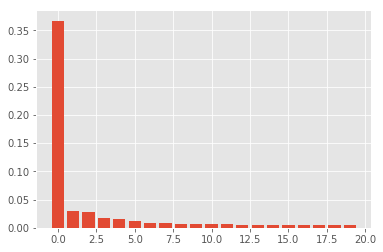

In [12]:
plt.bar(np.arange(num_factors), pca.explained_variance_ratio_)

In [13]:
def get_factor_betas(pca, factor_beta_indices, factor_beta_columns):
    df = pd.DataFrame(data=pca.components_.T, index=factor_beta_indices, columns=factor_beta_columns)
    return df

In [14]:
risk_model = {}
risk_model['factor_betas'] = get_factor_betas(pca, returns.columns, np.arange(num_factors))

risk_model['factor_betas'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
ticker,,,,,,,,,,,,,,,,,,,,
CSCO,-0.030690,-0.009687,-0.015840,-0.009042,0.016423,0.028864,0.004249,0.064281,0.026441,0.010427,-0.004932,-0.009326,0.021769,-0.006445,-0.001286,-0.037866,-0.000505,-0.020508,-0.001843,0.003556
UAL,-0.035815,0.058854,-0.082770,-0.043878,0.030754,0.014551,-0.010481,-0.248997,0.159158,0.134925,0.088940,-0.045186,-0.168403,0.073170,0.030309,-0.087125,-0.050252,0.040717,0.085563,0.009293
TROW,-0.043942,0.001353,-0.010571,0.023054,0.027019,-0.000720,0.002137,0.017874,0.008321,0.002124,-0.008048,-0.018244,-0.002498,0.012839,-0.015307,-0.000342,-0.017503,-0.028619,0.005087,0.009942
ISRG,-0.028431,0.015078,-0.012456,-0.021425,-0.017592,-0.002381,0.029276,0.003593,-0.021463,-0.000557,-0.022493,0.013708,0.002427,-0.056005,-0.033549,0.007589,-0.018473,0.005077,0.034922,-0.014080
NVR,-0.023390,0.012609,-0.021029,0.015785,-0.006125,0.013512,-0.004113,-0.079246,0.025627,-0.064356,-0.020709,0.055420,0.049126,0.006734,-0.052686,-0.043094,0.041883,0.011614,-0.035703,-0.005631


In [15]:
def get_factor_returns(pca, returns, factor_return_indices, factor_return_columns):
    return pd.DataFrame(data=pca.transform(returns), index=factor_return_indices, columns=factor_return_columns)

In [16]:
risk_model['factor_returns'] = get_factor_returns(pca, returns, returns.index, np.arange(num_factors))
risk_model['factor_returns'].head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2011-01-06,0.078550,0.024644,-0.024503,-0.082746,-0.011192,0.032135,-0.050340,0.013531,0.057236,0.037917,0.009698,0.046332,0.021737,0.004492,-0.034190,0.015693,0.065339,0.022827,0.055946,-0.019162
2011-01-07,0.044524,0.056101,0.120631,0.005794,-0.065673,0.065965,-0.006476,-0.074290,0.036041,0.043099,0.013008,0.050756,-0.007133,0.040996,-0.016106,0.025377,0.023405,0.010733,0.053097,-0.007370
2011-01-10,-0.076456,0.020069,0.058486,-0.088909,0.016202,0.061141,-0.009829,0.027431,-0.066682,0.027649,0.002301,-0.008045,-0.058269,0.017651,0.027136,-0.000710,0.006237,0.017326,-0.024419,0.001480
2011-01-11,-0.103621,-0.052697,0.061505,0.009042,0.001653,-0.066983,0.006267,0.056308,0.033497,-0.059726,-0.044519,0.011790,-0.032060,-0.037222,-0.026893,0.008646,0.014844,0.030834,-0.053523,-0.037650
2011-01-12,-0.220740,-0.046754,-0.000252,-0.000535,0.024119,0.004612,0.005136,-0.000834,0.016826,0.000950,-0.036271,0.028201,0.004797,0.044794,-0.007560,0.032653,0.009027,-0.042888,0.037760,0.013113


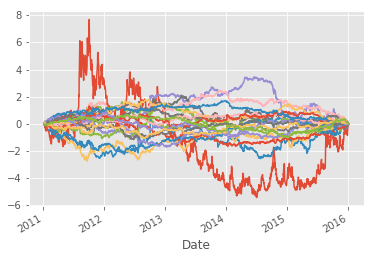

In [17]:
risk_model['factor_returns'].cumsum().plot(legend=None)

In [18]:
def create_factor_cov_matrix(factor_returns, ann_factor):
    var = factor_returns.var(ddof=1)*ann_factor
    return np.diag(var)

In [19]:
ann_factor = 252
risk_model['factor_cov_matrix'] = create_factor_cov_matrix(risk_model['factor_returns'], ann_factor)
risk_model['factor_cov_matrix']

array([[24.35811025,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.02925202,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.87350198,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.17953086,  0.        ,
         0.        ,  0.        ,  0.        ,  

In [20]:
def create_idiosyncratic_var_matrix(returns, factor_returns, factor_betas, ann_factor):
    common_returns = factor_returns.dot(factor_betas.T)
    s = returns - common_returns
    var_s = np.var(s)*ann_factor
    
    return pd.DataFrame(data=np.diag(var_s), index=returns.columns, columns=returns.columns)

In [21]:
risk_model['idiosyncratic_var_matrix'] = create_idiosyncratic_var_matrix(returns, risk_model['factor_returns'],
                                                                         risk_model['factor_betas'], ann_factor)

risk_model['idiosyncratic_var_matrix'].head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
ticker,,,,,,,,,,,,,,,,,,,,,
CSCO,0.038943,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UAL,0.000000,0.043546,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TROW,0.000000,0.000000,0.01434,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ISRG,0.000000,0.000000,0.00000,0.074459,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
NVR,0.000000,0.000000,0.00000,0.000000,0.027638,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
def create_idiosyncratic_var_vector(returns, idiosyncratic_var_matrix):
    return pd.DataFrame(np.diag(idiosyncratic_var_matrix), idiosyncratic_var_matrix.index)

In [23]:
risk_model['idiosyncratic_var_vector'] = create_idiosyncratic_var_vector(returns, 
                                                                         risk_model['idiosyncratic_var_matrix'])
risk_model['idiosyncratic_var_vector'].head()

,0
ticker,
CSCO,0.038943
UAL,0.043546
TROW,0.014340
ISRG,0.074459
NVR,0.027638


In [24]:
def predict_portfolio_risk(factor_betas, factor_cov_matrix, idiosyncratic_var_matrix, weights):
    weights = weights.values
    factor_var = np.add(factor_betas.dot(factor_cov_matrix.dot(factor_betas.T)), idiosyncratic_var_matrix)
    result = weights.T.dot(factor_var.dot(weights))
    return result[0][0]

In [25]:
initial_weights = pd.DataFrame(np.repeat(1/len(returns.columns), len(returns.columns)), returns.columns)
print(initial_weights.head())

print(risk_model['factor_betas'].shape)
print(risk_model['factor_cov_matrix'].shape)
print(risk_model['idiosyncratic_var_matrix'].shape)
print(initial_weights.shape)


predict_portfolio_risk(
    risk_model['factor_betas'],
    risk_model['factor_cov_matrix'],
    risk_model['idiosyncratic_var_matrix'],
    initial_weights
)

               0
ticker          
CSCO    0.001328
UAL     0.001328
TROW    0.001328
ISRG    0.001328
NVR     0.001328
(753, 20)
(20, 20)
(753, 753)
(753, 1)


0.029980280877638165

In [26]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [27]:
momentum = create_momentum_factor(p, sector_data)
print(momentum.shape)
momentum.head()

(1006, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.432151,-1.328634,-0.252854,1.691824,-0.381580,1.586085,1.149337,0.740173,-1.209103,1.057390,...,-0.721784,0.133323,-0.137920,-0.974638,-1.016014,1.622864,-1.121753,1.227492,0.110336,-0.174699
2012-01-06,-0.441345,-1.379205,-0.206881,1.687227,-0.579266,1.526320,1.130948,0.763160,-1.273466,1.057390,...,-0.570071,0.188491,-0.160907,-1.006819,-0.979235,1.590683,-1.084974,1.291855,0.220673,-0.165505
2012-01-09,-0.468930,-1.448165,-0.285036,1.664240,-0.735576,1.517125,1.181519,0.763160,-1.149337,1.034403,...,-0.547085,0.285036,-0.133323,-0.947054,-0.956249,1.590683,-1.029806,1.347023,0.142518,0.036779
2012-01-10,-0.501111,-1.507930,-0.179297,1.645851,-0.901080,1.558501,1.144740,0.574669,-1.218297,1.048196,...,-0.579266,0.321814,-0.211478,-0.514903,-1.034403,1.517125,-1.084974,1.273466,0.096544,-0.018389
2012-01-11,-0.464332,-1.452762,-0.308022,1.650448,-0.882691,1.503333,1.094169,0.285036,-1.241284,1.034403,...,-0.579266,0.335606,-0.211478,-0.473527,-1.061988,1.512528,-0.997625,1.333231,0.110336,-0.133323


In [28]:
def create_mean_reversion_factor(window_length, prices, sector_data):
    sectors = sector_data.unique()
    df = prices.pct_change(window_length).dropna()
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first', ascending=False)
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [29]:
mean_reversion = create_mean_reversion_factor(5, p, sector_data)
print(mean_reversion.shape)
mean_reversion.head()

(1253, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-12,0.225270,-0.376983,-1.029806,-0.786147,-1.701019,-1.287258,-0.850510,-1.250479,-0.781549,-1.071182,...,1.374607,1.595280,-0.395372,1.599877,-1.466554,-1.232089,0.220673,0.818328,-0.432151,0.753965
2011-01-13,0.514903,0.468930,-1.103364,-1.112558,-1.664240,0.767757,-1.043598,-0.671213,-0.790744,-0.827523,...,0.583863,1.438970,0.101142,1.659643,-1.521722,-1.305647,1.471152,-0.487319,-1.287258,1.549307
2011-01-14,1.039001,1.241284,-1.029806,-1.567696,-1.650448,0.243659,-0.905678,-0.836717,-0.914872,-0.606850,...,0.321814,1.324036,-0.510306,0.331009,-1.682630,-1.402191,1.328634,-1.370010,-1.287258,1.406789
2011-01-18,0.547085,1.645851,-1.061988,-1.595280,-1.599877,1.048196,-1.002222,-0.193089,-1.232089,-0.726381,...,-0.450540,0.905678,-0.556279,0.243659,-1.484944,0.262049,1.199908,-0.983833,-0.128726,1.512528
2011-01-19,0.859704,1.599877,-0.657421,-1.425178,-1.659643,0.565474,0.776952,0.193089,-0.514903,-1.034403,...,0.657421,0.496514,-0.468930,0.404567,-0.698797,-0.712589,1.176921,-0.960846,0.662018,1.342426


In [30]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [31]:
smoothed_mean_reversion = create_smoothed_factor(mean_reversion, 5)
print(smoothed_mean_reversion.shape)
smoothed_mean_reversion.head()

(1249, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-19,0.901080,1.227492,-1.264271,-1.535515,-1.710214,0.399969,-0.878094,-0.790744,-1.163129,-1.176921,...,0.698797,1.429776,-0.551682,1.144740,-1.576891,-1.190713,1.360815,-0.864302,-0.717186,1.544709
2011-01-20,0.956249,1.572293,-1.006819,-1.636656,-1.710214,0.294230,-0.514903,-0.344801,-1.190713,-0.983833,...,0.487319,1.314842,-0.225270,0.891886,-1.494138,-0.956249,1.563099,-1.011417,-0.482722,1.641254
2011-01-21,0.772355,1.673435,-0.616045,-1.678032,-1.627462,-0.482722,0.036779,-0.091947,-1.172324,-1.094169,...,0.197686,1.167727,-0.197686,0.409164,-1.310244,-0.505708,1.443568,-0.551682,0.114934,1.475749
2011-01-24,0.257452,1.691824,-0.202283,-1.668838,-1.209103,-0.970041,0.528695,0.358593,-1.287258,-1.181519,...,-0.229867,0.970041,0.078155,0.542487,-1.039001,0.220673,1.140143,0.303425,0.726381,1.222895
2011-01-25,-0.349399,1.641254,0.216075,-1.696422,-0.629837,-1.489541,1.061988,0.593058,-1.264271,-1.319439,...,-0.353996,0.730978,0.436748,0.818328,-0.970041,0.280438,0.868899,0.947054,0.514903,0.924067


In [32]:
smoothed_momentum = create_smoothed_factor(momentum, window=5)
print(smoothed_momentum.shape)
smoothed_momentum.head()

(1002, 753)


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,WAT,NNN,IEX,BWA,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-11,-0.459735,-1.425178,-0.285036,1.664240,-0.694200,1.544709,1.144740,0.639031,-1.222895,1.052793,...,-0.588461,0.248257,-0.156310,-0.809133,-0.993027,1.572293,-1.052793,1.310244,0.137920,-0.110336
2012-01-12,-0.473527,-1.443568,-0.294230,1.650448,-0.836717,1.521722,1.144740,0.514903,-1.213700,1.043598,...,-0.560877,0.298828,-0.188491,-0.657421,-1.006819,1.563099,-1.034403,1.324036,0.151713,-0.101142
2012-01-13,-0.455138,-1.443568,-0.321814,1.645851,-0.896483,1.517125,1.149337,0.459735,-1.199908,1.029806,...,-0.556279,0.326412,-0.188491,-0.519500,-1.043598,1.544709,-1.029806,1.324036,0.119531,-0.050571
2012-01-17,-0.450540,-1.425178,-0.340204,1.645851,-0.956249,1.507930,1.140143,0.395372,-1.204505,1.006819,...,-0.528695,0.340204,-0.183894,-0.404567,-1.084974,1.526320,-1.048196,1.328634,0.110336,-0.045973
2012-01-18,-0.432151,-1.411386,-0.381580,1.641254,-0.970041,1.517125,1.135545,0.390775,-1.209103,0.988430,...,-0.528695,0.340204,-0.179297,-0.386177,-1.103364,1.535515,-1.043598,1.296452,0.137920,0.004597


In [33]:
index = smoothed_momentum.index.intersection(smoothed_mean_reversion.index)
m = momentum.loc[index,:].stack()
print(m.shape)
sm = smoothed_momentum.loc[index,:].stack()
print(sm.shape)
mr = mean_reversion.loc[index, :].stack()
print(mr.shape)
smr = smoothed_mean_reversion.loc[index, :].stack()
print(smr.shape)
adj_p = p.loc[index,:].copy()
print(adj_p.shape)

(754506,)
(754506,)
(754506,)
(754506,)
(1002, 753)


In [34]:
factor_data = {}
factor_data['momentum'] = al.utils.get_clean_factor_and_forward_returns(m, adj_p, periods=[1])
factor_data['smoothed_momentum'] = al.utils.get_clean_factor_and_forward_returns(sm, adj_p, periods=[1])
factor_data['mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(mr, adj_p, periods=[1])
factor_data['smoothed_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(smr, adj_p, periods=[1])

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [35]:
factor_data['momentum'].head()

1D    factor  factor_quantile
date       asset                                     
2012-01-11 CSCO   0.004195 -0.464332                2
           UAL    0.028873 -1.452762                1
           TROW   0.000674 -0.308022                3
           ISRG   0.002582  1.650448                5
           NVR    0.000000 -0.882691                2

In [36]:
factor_returns_df = pd.DataFrame()
for key, val in factor_data.items():
    factor_returns_df[key] = al.performance.factor_returns(val).iloc[:,0]
factor_returns_df.head()

,smoothed_momentum,mean_reversion,momentum,smoothed_mean_reversion
date,,,,
2012-01-11,-0.001640,-0.001490,-0.001464,-0.000655
2012-01-12,0.003564,0.000603,0.003602,0.000595
2012-01-13,0.001735,0.000762,0.001710,0.000984
2012-01-17,-0.005213,-0.000124,-0.005278,-0.001924
2012-01-18,-0.004896,-0.000725,-0.004930,-0.000450


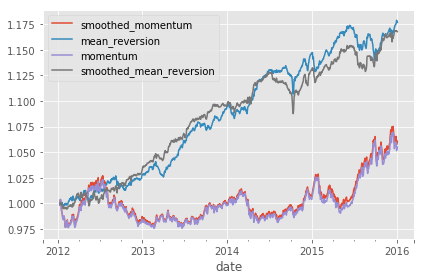

In [37]:
(1+factor_returns_df).cumprod().plot()
plt.tight_layout()

# Quantile Analysis

In [38]:
factor_names = factor_data.keys()
factor_names

dict_keys(['smoothed_momentum', 'mean_reversion', 'momentum', 'smoothed_mean_reversion'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x120b9c2b0>,
      dtype=object)

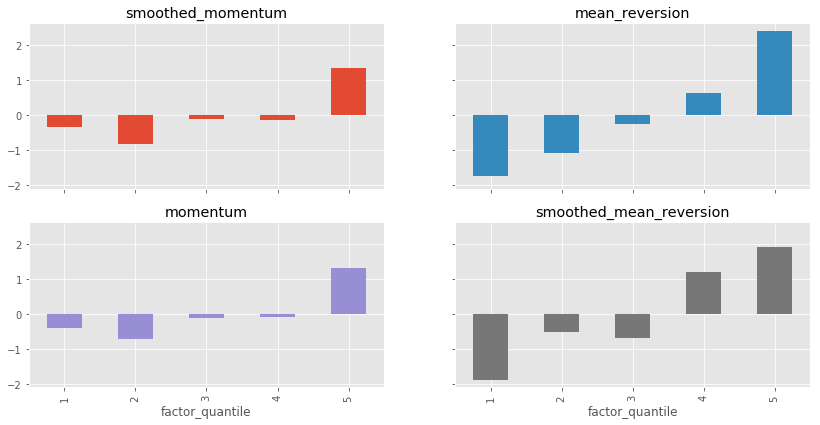

In [39]:
qr_factor_returns = pd.DataFrame()
for key, val in factor_data.items():
    qr_factor_returns[key] = al.performance.mean_return_by_quantile(val)[0].iloc[:,0]


(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey = True,
    layout=(4,2),
    figsize=(14,14),
    legend=False
)

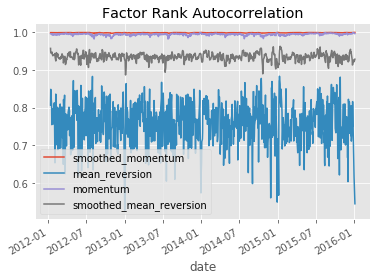

In [40]:
# Turnover analysis

fra_df = pd.DataFrame()

for key, val in factor_data.items():
    fra_df[key] = al.performance.factor_rank_autocorrelation(val)
    
fra_df.plot(title='Factor Rank Autocorrelation')

## sharpe ratio of the alphas

In [41]:
def get_sharpe_ratio(factor_returns, ann_factor):
    sharpe = factor_returns.mean() / (factor_returns.std())
    return sharpe * ann_factor

In [42]:
ann_factor = np.sqrt(252)
get_sharpe_ratio(factor_returns_df, ann_factor).round(2)

smoothed_momentum          0.48
mean_reversion             1.92
momentum                   0.44
smoothed_mean_reversion    1.84
dtype: float64

# The combined alpha vector

In [43]:
all_factors_df = pd.DataFrame()
for key, val in factor_data.items():
    all_factors_df[key] = val.loc[:,'factor']
all_factors_df.head()

smoothed_momentum  mean_reversion  momentum  \
date       asset                                                
2012-01-11 CSCO           -0.459735        1.314842 -0.464332   
           UAL            -1.425178        1.581488 -1.452762   
           TROW           -0.285036       -0.041376 -0.308022   
           ISRG            1.664240        1.609072  1.650448   
           NVR            -0.694200        0.436748 -0.882691   

                  smoothed_mean_reversion  
date       asset                           
2012-01-11 CSCO                 -0.367788  
           UAL                   1.678032  
           TROW                 -0.275841  
           ISRG                  1.301050  
           NVR                  -0.395372

In [44]:
selected_factors = ['smoothed_mean_reversion', 'mean_reversion']
all_factors_df['alpha_vector'] = all_factors_df[selected_factors].mean(axis=1)
alphas = all_factors_df[['alpha_vector']]
alpha_vector = alphas.loc[all_factors_df.index.get_level_values(0)[-1]]
alpha_vector.head()

,alpha_vector
asset,
CSCO,-0.733277
UAL,1.521722
TROW,-0.064363
ISRG,-0.896483
NVR,1.622864


# Optimal Portfolio Constrained by Risk Model

In [45]:
from abc import ABC, abstractmethod

In [46]:

class AbstractOptimalHoldings(ABC):    
    @abstractmethod
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        
        raise NotImplementedError()
    
    @abstractmethod
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        
        raise NotImplementedError()
        
    def _get_risk(self, weights, factor_betas, alpha_vector_index, factor_cov_matrix, idiosyncratic_var_vector):
        f = factor_betas.loc[alpha_vector_index].values.T * weights
        X = factor_cov_matrix
        S = np.diag(idiosyncratic_var_vector.loc[alpha_vector_index].values.flatten())

        return cvx.quad_form(f, X) + cvx.quad_form(weights, S)
    
    def find(self, alpha_vector, factor_betas, factor_cov_matrix, idiosyncratic_var_vector):
        weights = cvx.Variable(len(alpha_vector))
        risk = self._get_risk(weights, factor_betas, alpha_vector.index, factor_cov_matrix, idiosyncratic_var_vector)
        
        obj = self._get_obj(weights, alpha_vector)
        constraints = self._get_constraints(weights, factor_betas.loc[alpha_vector.index].values, risk)
        
        prob = cvx.Problem(obj, constraints)
        prob.solve(max_iters=1000)

        optimal_weights = np.asarray(weights.value).flatten()
        
        return pd.DataFrame(data=optimal_weights, index=alpha_vector.index)

In [47]:
class OptimalHoldings(AbstractOptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)

        #TODO: Implement function
        av = -alpha_vector
        return cvx.Minimize(np.array(av.T) @ weights)
    
    def _get_constraints(self, weights, factor_betas, risk):
        """
        Get the constraints

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        factor_betas : 2 dimensional Ndarray
            Factor betas
        risk: CVXPY Atom
            Predicted variance of the portfolio returns

        Returns
        -------
        constraints : List of CVXPY Constraint
            Constraints
        """
        assert(len(factor_betas.shape) == 2)
        
        #TODO: Implement function=
        
        return [risk <= self.risk_cap**2, factor_betas.T @ weights <= self.factor_max, factor_betas.T @ weights >= self.factor_min, \
                sum(weights) == 0, sum(cvx.abs(weights)) <= 1, weights >= self.weights_min, weights <= self.weights_max]

    def __init__(self, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55, weights_min=-0.55):
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

In [48]:
print(risk_model.keys())
optimal_weights = OptimalHoldings().find(alpha_vector, risk_model['factor_betas'], 
                                         risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

dict_keys(['factor_betas', 'factor_cov_matrix', 'idiosyncratic_var_matrix', 'idiosyncratic_var_vector', 'factor_returns'])


/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


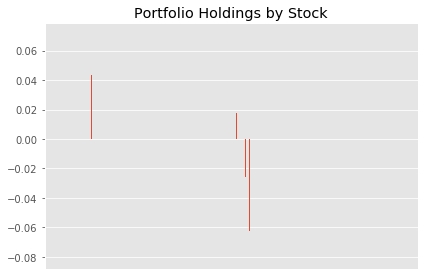

In [49]:
optimal_weights.plot.bar(legend=None, title='Portfolio Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.rcParams['figure.figsize'] = (14,14)
plt.tight_layout()

# Optimize with a Regularization Parameter

In [50]:
class OptimalHoldingsReg(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        assert(len(alpha_vector.columns)==1)
        return cvx.Maximize(np.array(alpha_vector.T) @ weights - self.lambda_reg * cvx.norm(weights, 2))
    
    def __init__(self, lambda_reg=0.50, risk_cap=0.05, factor_max=10.0, factor_min=-10.0, weights_max=0.55,
                 weights_min=-0.55):
        self.lambda_reg = lambda_reg
        self.risk_cap=risk_cap
        self.factor_max=factor_max
        self.factor_min=factor_min
        self.weights_max=weights_max
        self.weights_min=weights_min

this is seconds:  37.65913796424866


/Users/richard.wuebker/.pyenv/versions/zipline/lib/python3.5/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


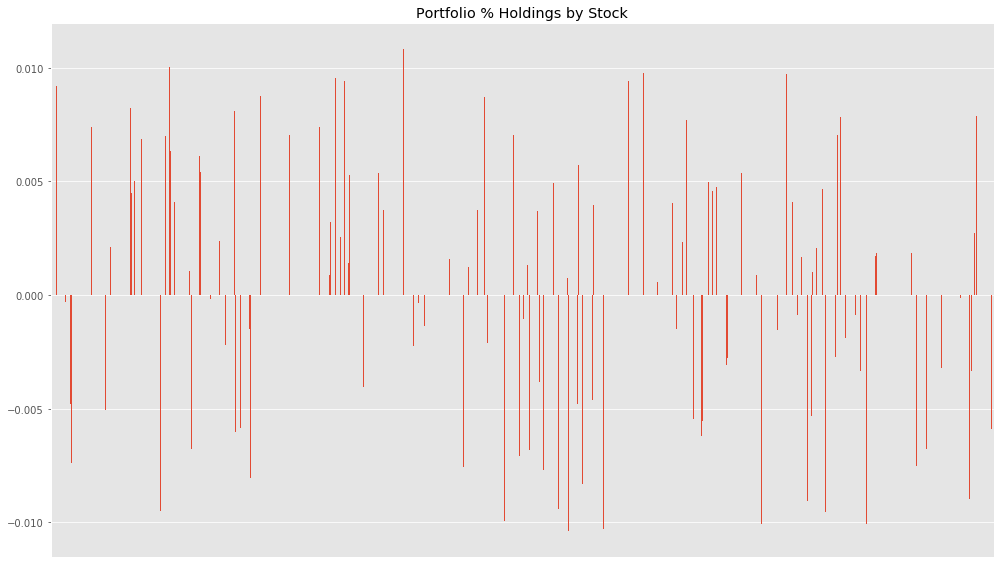

In [56]:
start = time.time()
optimal_weights_1 = OptimalHoldingsReg(lambda_reg=5.0).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])
end = time.time()
print('this is seconds: ', end-start)
optimal_weights_1.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.rcParams['figure.figsize'] = (14,14)
plt.tight_layout()

# Optimize with a Strict Factor Constraints and Target Weighting

In [52]:
class OptimalHoldingsStrictFactor(OptimalHoldings):
    def _get_obj(self, weights, alpha_vector):
        """
        Get the objective function

        Parameters
        ----------
        weights : CVXPY Variable
            Portfolio weights
        alpha_vector : DataFrame
            Alpha vector

        Returns
        -------
        objective : CVXPY Objective
            Objective function
        """
        assert(len(alpha_vector.columns) == 1)
        
        #TODO: Implement function
        alpha_vector1 = np.array(alpha_vector)
        #Lesson 29-8
        x_star = (alpha_vector1 - alpha_vector1.mean())/sum(abs(alpha_vector1))

        return cvx.Minimize(cvx.norm(weights-x_star.reshape(len(x_star),),2, ))

In [53]:
optimal_weights_2 = OptimalHoldingsStrictFactor(
    weights_max=0.02,
    weights_min=-0.02,
    risk_cap=0.05,
    factor_max=0.015,
    factor_min=-0.015).find(alpha_vector, risk_model['factor_betas'], risk_model['factor_cov_matrix'], risk_model['idiosyncratic_var_vector'])

optimal_weights_2.plot.bar(legend=None, title='Portfolio % Holdings by Stock')
x_axis = plt.axes().get_xaxis()
x_axis.set_visible(False)
plt.rcParams['figure.figsize'] = (14,14)
plt.tight_layout()

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.